In [1]:
using DataFrames, Gadfly, Vega, Plots
comment = "../datasets/facebook/Cheltenham's Facebook Groups/comment.csv"
like = "../datasets/facebook/Cheltenham's Facebook Groups/like.csv"
post = "../datasets/facebook/Cheltenham's Facebook Groups/post.csv"

# Read all datasets

#
# comment.csv 23.6 MB
#

@time df_comments = readtable(comment)

#
# like.csv 16.1 MB
#

@time df_likes = readtable(like)

#
# posts.csv 6.6 MB
#

@time df_posts = readtable(post)

# punchat of the time vs number likes/comments posts
# profile of people who have more likes in their posts

com_count = by(df_comments, :pid, df_comments->size(df_comments[:timeStamp],1))
post_df = df_posts
post_df = join(post_df, com_count, on=:pid)[[:name,:likes,:shares,:x1,:gid]]
names!(post_df, [:name,:likes,:shares,:hour,:gid])

sorted_posts = completecases!(sort(post_df,cols=:likes, rev=true))
top10_names = sorted_posts[:name][1:10]
top10_likes = sorted_posts[:likes][1:10]

number_of_posts_name = by(sorted_posts, :name, nrow)
sort!(number_of_posts_name, cols = :x1, rev=true)

most_posts = number_of_posts_name[:name][1:10]
number_posts = number_of_posts_name[:x1][1:10]
@show typeof(number_posts)

@time function get_avg_likes(name::String, n_posts::Int32)
    current = sorted_posts[sorted_posts[:name] .== name,:]
    likes = 0
    for l in current[:likes]
        likes += l
    end
    likes = likes / n_posts
    return likes
end

@time function get_avg_shares(name::String, n_posts::Int32)
    current = sorted_posts[sorted_posts[:name] .== name,:]
    shares = 0
    for l in current[:shares]
        shares += l
    end
    shares = shares / n_posts
    return shares
end

avg_likes = []
avg_shares = []
for i in 1:length(most_posts)
    push!(avg_likes, get_avg_likes(most_posts[i],Int32(number_posts[i])))
    push!(avg_shares, get_avg_shares(most_posts[i],Int32(number_posts[i])))
end

  2.551866 seconds (6.74 M allocations: 297.437 MB, 6.31% gc time)
  0.219334 seconds (3.77 M allocations: 192.156 MB, 23.00% gc time)
  0.608992 seconds (436.55 k allocations: 33.175 MB, 54.74% gc time)
typeof(number_posts) = DataArrays.DataArray{Int64,1}
  0.000282 seconds (25 allocations: 1.641 KB)
  0.000058 seconds (22 allocations: 1.517 KB)


In [2]:
#Relation between number of likes top users get in their posts and number of comments they made
comments_name_count = by(df_comments, :name, nrow)
df_join = join(sorted_posts, comments_name_count, on = :name)
df_names = df_join[[:name,:x1, :likes,:shares,:gid]]
names!(df_names, [:name, :num_comments, :total_likes_posts, :total_shares_posts,:gid])
sort!(df_names,cols = :total_likes_posts, rev=true )
size(df_names)


######### 



# Generate a new column hour to store hour value which comes from the
# timeStamp field
# Als post count to keep track of the number of posts


function replacena!(dframe::DataFrame, replacement::Any)
    nrows, ncols = size(dframe)
    for j = 1:ncols; for i = 1:nrows
            if isna(dframe[i,j]); dframe[i,j] = replacement; end
        end
    end
end

function timestamp_parse(df::DataArray)
  array = []
  for i in 1:size(df,1)
    tmp = split(df[i], " ")
    date = tmp[1]
    hours = tmp[2]
    date = split(date, "-")
    hours = split(hours, ":")
    year, month, day = date
    hour, minutes, seconds = hours
    dt=DateTime(parse(Int64, year), parse(Int64, month),parse(Int64, day), parse(Int64, hour), parse(Int64, minutes), parse(Int64, seconds))

    array = push!(array, dt)
  end
  return array
end

@time dates = timestamp_parse(df_posts[:timeStamp])

df_posts[:hour] = [Dates.hour(date) for date in dates]
df_posts[:month] = [Dates.month(date) for date in dates]
df_posts[:count_posts]=1

columns = [:hour, :shares, :likes, :count_posts, :month]
filtered_posts = df_posts[columns]
replacena!(filtered_posts, 0)
posts_by_hour = aggregate(filtered_posts, :hour, sum)

size(posts_by_hour)



  0.040182 seconds (246.78 k allocations: 10.549 MB)


(24,5)


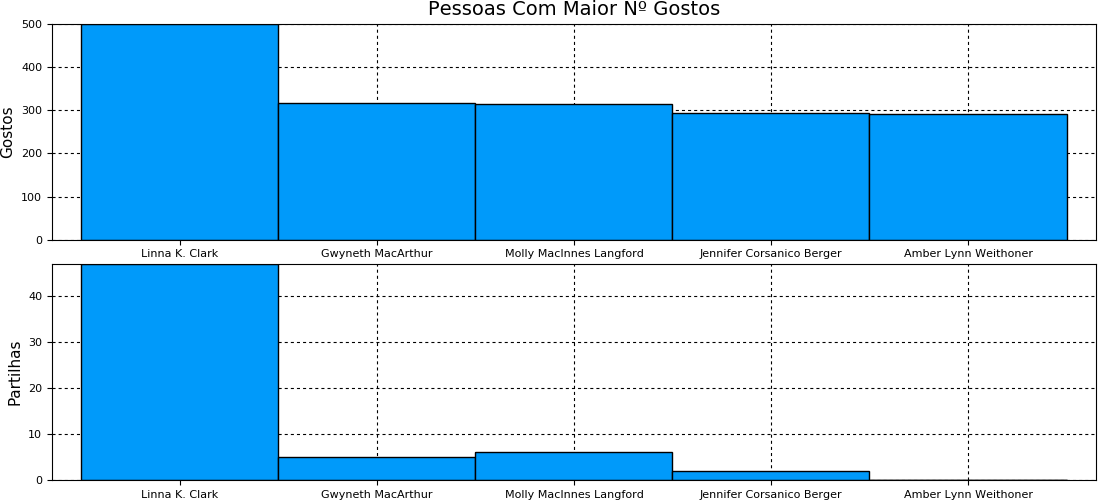

In [157]:
likes_5 = sort(df_names, cols=[:total_likes_posts], rev=true)[1:5,:]
shares_5 = sort(df_names, cols=[:total_shares_posts], rev=true)[1:5,:]
p1 = Plots.bar(likes_5[:name], likes_5[:total_likes_posts],title = "Pessoas Com Maior Nº Gostos", ylabel = "Gostos")
p2 = Plots.bar(likes_5[:name], likes_5[:total_shares_posts], ylabel = "Partilhas")
p3 = Plots.bar(shares_5[:name], shares_5[:total_likes_posts], color=:green, title = "Pessoas Com Maior Nº Partilhas", ylabel = "Gostos")
p4 = Plots.bar(shares_5[:name], shares_5[:total_shares_posts], color=:green, ylabel = "Partilhas")
Plots.plot(p1,p2, layout = grid(2,1), legend= false, size=(1100,500))


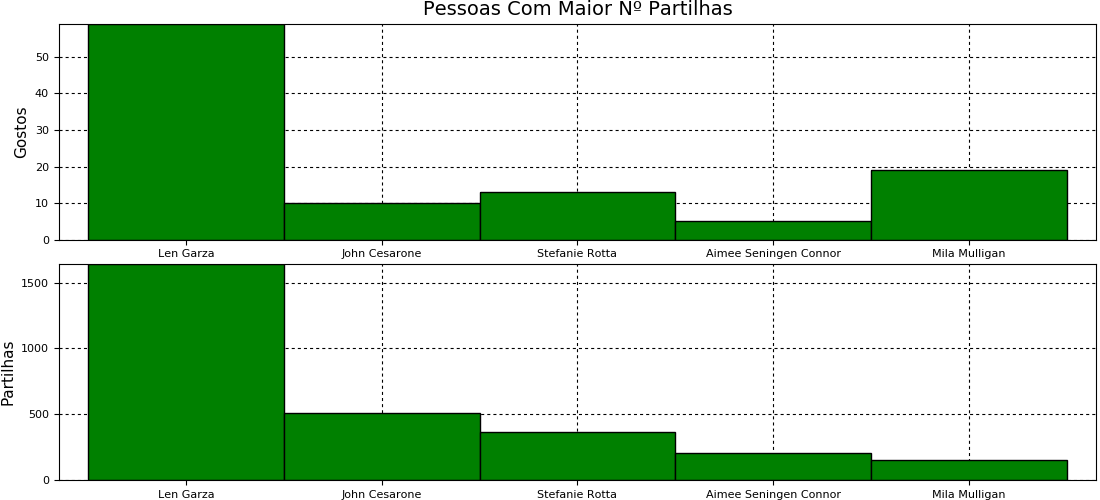

In [158]:
Plots.plot(p3,p4, layout = grid(2,1), legend= false, size=(1100,500))


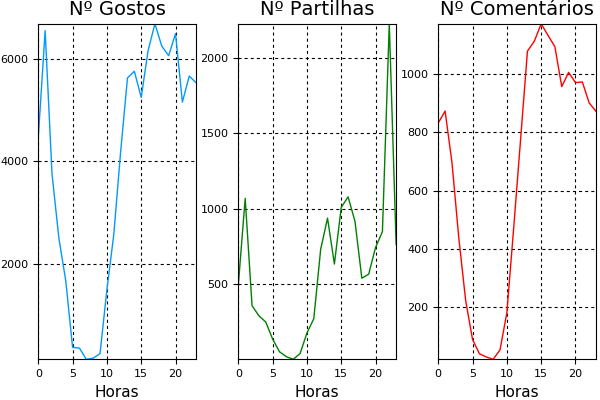

In [30]:
#=plot( Guide.XLabel("Horas"), Guide.YLabel(nothing), Scale.y_distribution,
      Gadfly.layer(posts_by_hour, x=:hour, y=:likes_sum, Geom.line,Theme(default_color=colorant"red")),
      Gadfly.layer(posts_by_hour, x=:hour, y=:shares_sum, Geom.line,Theme(default_color=colorant"blue")),
      Gadfly.layer(posts_by_hour, x=:hour, y=:count_posts_sum, Geom.line,Theme(default_color=colorant"green")),
      Guide.manual_color_key("", ["Gostos", "Partilhas", "Nº Posts"], ["red", "blue","green"]))=#
p_likes = Plots.plot(posts_by_hour[:hour], posts_by_hour[:likes_sum], title = "Nº Gostos")
p_shares = Plots.plot(posts_by_hour[:hour], posts_by_hour[:shares_sum], color=:green, title = "Nº Partilhas")
p_com = Plots.plot(posts_by_hour[:hour], posts_by_hour[:count_posts_sum], color=:red, title = "Nº Comentários")
Plots.plot(p_likes, p_shares, p_com,  layout = grid(1,3), legend= false, xlabel = "Horas")


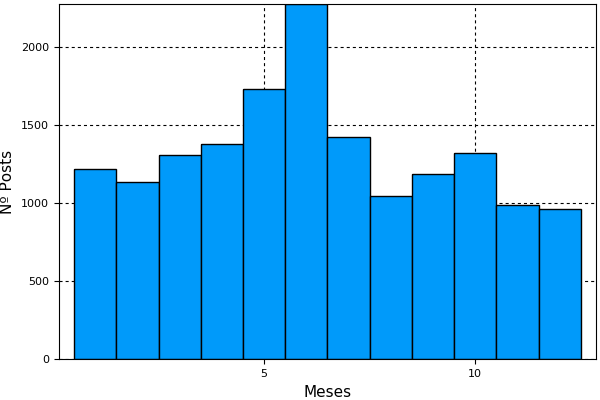

In [5]:
posts_by_month = aggregate(filtered_posts, :month, sum)
#plot(posts_by_month, x=:month, y = :count_posts_sum, Geom.line, Coord.cartesian(xmin=1, xmax=12),
#    Scale.x_discrete,  Guide.XLabel("Month"), Guide.ylabel("Number Posts"))
#a = barplot(x = posts_by_month[:month], y = posts_by_month[:count_posts_sum])
#ylab!(a, title = "Mês")
#xlab!(a, title = "Nº Posts")
Plots.bar(posts_by_month[:month], posts_by_month[:count_posts_sum], xlabel = "Meses", ylabel = "Nº Posts", legend = false)

In [7]:
describe(posts_by_month)

month
Summary Stats:
Mean:           6.500000
Minimum:        1.000000
1st Quartile:   3.750000
Median:         6.500000
3rd Quartile:   9.250000
Maximum:        12.000000
Length:         12
Type:           Int64

hour_sum
Summary Stats:
Mean:           18521.583333
Minimum:        13078.000000
1st Quartile:   15628.000000
Median:         17750.500000
3rd Quartile:   19443.250000
Maximum:        31145.000000
Length:         12
Type:           Int64

shares_sum
Summary Stats:
Mean:           1176.500000
Minimum:        526.000000
1st Quartile:   721.500000
Median:         867.000000
3rd Quartile:   1496.000000
Maximum:        3157.000000
Length:         12
Type:           Int64

likes_sum
Summary Stats:
Mean:           7750.916667
Minimum:        5059.000000
1st Quartile:   5474.250000
Median:         6832.000000
3rd Quartile:   8962.750000
Maximum:        15504.000000
Length:         12
Type:           Float64

count_posts_sum
Summary Stats:
Mean:           1332.083333
Minimum:        

### We can see that in june there is more posts that the other months. The mean is 1332 posts/month but in june we have 2278 posts.
## Trying to understand why looking at word frequency and applying TFIDF to find the most similar posts

In [7]:
### Why so many posts in june??
using PyCall
@pyimport nltk as nltk
@pyimport nltk.corpus as cNltk

june_posts = df_posts[df_posts[:month] .== 6,:]
@show size(june_posts)

june_posts = dropna(june_posts[:msg])


cleaned_june_posts = []
for s in june_posts
    s = replace(s, r"\{COMMA}", ",")
    s = replace(s, r"\{APOST}", "'")
    s = replace(s, r"\{RET}", " ")
    s = replace(s, r"[^a-zA-Z]", " ")
    s = lowercase(s)
    push!(cleaned_june_posts, s)
end

str = " "
for s in cleaned_june_posts
    str = str * string(s) * " "
end



allWords = nltk.tokenize[:word_tokenize](str)
allWordsDist = nltk.FreqDist([w for w in allWords if !in(w, cNltk.stopwords[:words]("english"))])

allWordsDist = sort(collect(zip(values(allWordsDist),keys(allWordsDist))), rev = true)            

size(june_posts) = (2278,12)


/usr/local/lib/python2.7/dist-packages/nltk/app/__init__.py:28: UserWarning: nltk.app package not loaded (please install Tkinter library).
  warnings.warn("nltk.app package not loaded "
/usr/local/lib/python2.7/dist-packages/nltk/draw/__init__.py:14: UserWarning: nltk.draw package not loaded (please install Tkinter library).
  warnings.warn("nltk.draw package not loaded "


6971-element Array{Tuple{Any,Any},1}:
 (485,"park")        
 (398,"please")      
 (395,"anyone")      
 (323,"cheltenham")  
 (314,"elkins")      
 (305,"know")        
 (284,"looking")     
 (279,"pm")          
 (271,"school")      
 (265,"thanks")      
 (232,"township")    
 (224,"june")        
 (221,"would")       
 ⋮                   
 (1,"accounts")      
 (1,"accomplishment")
 (1,"accommodate")   
 (1,"abuse")         
 (1,"absolutely")    
 (1,"abrams")        
 (1,"ablaze")        
 (1,"abingtonclub")  
 (1,"abbyroeser")    
 (1,"ab")            
 (1,"aaro")          
 (1,"aaargh")        

In [9]:
using TextAnalysis
crps = Corpus(Any[StringDocument(sd) for sd in cleaned_june_posts])
remove_punctuation!(crps)
update_lexicon!(crps)
m = DocumentTermMatrix(crps)
t = tf_idf(m)

2277×7112 sparse matrix with 70620 Float64 nonzero entries:
	[2   ,    1]  =  0.0188893
	[3   ,    1]  =  0.0475278
	[4   ,    1]  =  0.0350801
	[5   ,    1]  =  0.0320296
	[6   ,    1]  =  0.0368341
	[7   ,    1]  =  0.0491121
	[10  ,    1]  =  0.0818535
	[13  ,    1]  =  0.0156741
	[14  ,    1]  =  0.0460426
	[15  ,    1]  =  0.0387727
	⋮
	[1749, 7108]  =  0.63977
	[1948, 7108]  =  0.117291
	[863 , 7109]  =  0.0348389
	[2165, 7109]  =  0.0348389
	[1250, 7110]  =  0.167559
	[1970, 7110]  =  0.20107
	[828 , 7111]  =  0.0376335
	[2126, 7111]  =  0.0376335
	[1261, 7112]  =  0.106968
	[1324, 7112]  =  0.457379
	[1381, 7112]  =  0.147378

In [10]:
@pyimport sklearn.feature_extraction.text as sk_text
@pyimport sklearn.metrics.pairwise as sk_metrics
tfidf = sk_text.TfidfVectorizer()[:fit_transform](cleaned_june_posts)
cs = sk_metrics.linear_kernel(tfidf[length(cleaned_june_posts)-1], tfidf)

related_doc_indices = sortperm(vec(cs))[end-10:end]

11-element Array{Int64,1}:
  155
 1575
 1034
 1018
  931
 2140
 1011
  111
 1526
  986
 2276

In [11]:
cs = vec(cs)
cs[related_doc_indices]
similar_doc = []
for index in related_doc_indices
    println(cleaned_june_posts[index],"\n")
    push!(similar_doc, cleaned_june_posts[index])
end

hello  i am cynthia blackwood  president of high school park  and i would like to answer questions which have been posed on facebook  sent in emails or by phone concerning the postponement of arts in the park to the following sunday  june   th   we made the call on thursday afternoon in anticipation of the storms  to give advance notice to our artists  vendors  sponsors  tent  table   stage companies   all of whom were aware of the rain date and had committed to that date when first negotiated   arts in the park  is an annual festival created by the friends of high school park  a small but devoted volunteer group   our festival is the main fundraiser for our working budget   with this budget we are able to maintain  enhance and develop this    acre park  a park which is owned by cheltenham township  but tended dearly by the friends of high school park for the benefit of the entire community  near or far    this year is our   st arts in the park      years  with the exception of one  wi

inspection schedule for the week of june         is here   waiting on glenside contractor   cheltenham village   jefferson franklin  myrtle laurel  beecher cottman ryers central old soldiers and  woodland   cheltenham village here s what i know is going on with your   neck of the woods  they will be starting flushing and videoing the personal laterals   the contractor has added a sub contractor to help move the process forward   the contract was signed was for     days   it was signed on january             july         would be the end date  the possibility that it be extended is being discussed  the scope of work has been extensive   not only inspecting the mains but cleaning and doing maintenance   as for when will you will receive the report on your property    that process is in the works  yesterday in my weekly conversation   they are in the process of cataloging the reports so far and then working on a disbursement plan to get reports  to property owners    as to whether your pr

In [12]:
wc = wordcloud(x = similar_doc ,minThreshold=5, wordAngles = [0, 90])
colorscheme!(wc, palette = ("Spectral", 5))

In [13]:
filtered = df_posts[findin(df_posts[:name],[n for n in top10_names]),:]

######################
# Comments
######################
@time dates_comments = timestamp_parse(df_comments[:timeStamp])
df_comments[:hour] = [Dates.hour(date) for date in dates_comments]

df_comments[:count_comment] = 1
comment_columns =[:hour, :count_comment]
filtered_comments = df_comments[comment_columns]
comments_by_hour = aggregate(filtered_comments, :hour, sum)

  0.207863 seconds (1.63 M allocations: 69.936 MB, 16.44% gc time)


,hour,count_comment_sum
1,0,7180
2,1,8030
3,2,6982
4,3,4903
5,4,2495
6,5,1045
7,6,522
8,7,304
9,8,297
10,9,489


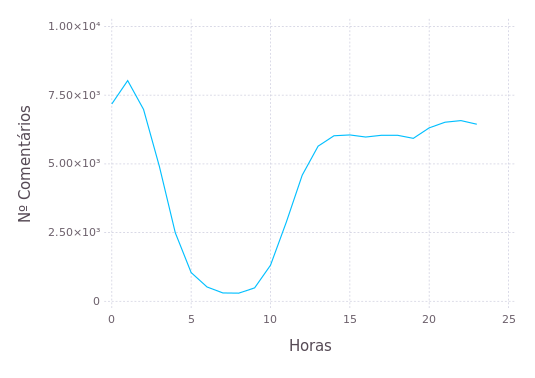

In [15]:
Gadfly.plot(comments_by_hour, x=:hour , y=:count_comment_sum, Geom.line, Guide.xlabel("Horas"), Guide.ylabel("Nº Comentários"))

In [16]:
posts_msg = df_posts
posts_msg = posts_msg[[:gid,:name,:shares,:likes,:msg]]
sort!(posts_msg, cols = :likes, rev = true)
posts_20 = posts_msg[1:20,:]
content = posts_20[:msg]

function clean_content(posts)
    cleaned_posts = []
    for s in posts
        s = replace(s, r"\{COMMA}", ",")
        s = replace(s, r"\{APOST}", "'")
        s = replace(s, r"\{RET}", " ")
        s = replace(s, r"[^a-zA-Z]", " ")
        s = lowercase(s)
        push!(cleaned_posts, s)
    end
    return cleaned_posts
end

clean = clean_content(content)
wordcloud(x = clean)

#### Next Step: Use a Genderizer to classify the gender based on the first name
##### After having the gender look at ingormation like, who gets more likes, more comments, o writes the most, who writes the longest comments, words most used by gender

In [17]:
using PyCall
@pyimport gender_guesser.detector as gender_guesser

In [18]:
function genderize_names(names)
    gender = []
    d = gender_guesser.Detector()
    for n in names
        name = split(n)
        g =  d[:get_gender](name[1])
        push!(gender, g)
    end
    return gender
end

genderize_names (generic function with 1 method)

In [19]:
genders1 = genderize_names(df_posts[:name])
unique(genders1)
df_posts[:gender] = genders1
size(df_posts)

filtered_by_gender = df_posts[(df_posts[:gender] .== "female") | (df_posts[:gender] .== "male") | (df_posts[:gender] .== "mostly_female") | (df_posts[:gender] .== "mostly_male"),:]
filtered_by_gender[:gender] = map(e -> replace(string(e), "mostly_female","female"), filtered_by_gender[:gender])
filtered_by_gender[:gender] = map(e -> replace(string(e), "mostly_male","male"), filtered_by_gender[:gender])

occurences = by(filtered_by_gender, :gender, nrow)



,gender,x1
1,female,9752
2,male,5181



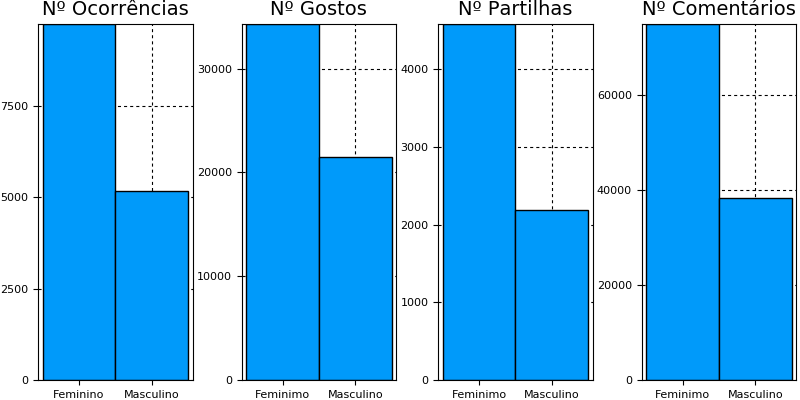

In [52]:
comments_name_count = by(df_comments, :pid, nrow)
df_comments_filtered = join(filtered_by_gender, comments_name_count, on = :pid)
df_sum = df_comments_filtered[[:shares, :likes,:x1, :gender]]
df_sum = aggregate(df_sum, :gender, sum)

a = Plots.bar(["Feminino","Masculino"], occurences[:x1], title="Nº Ocorrências", legend = false)
b = Plots.bar(["Feminimo","Masculino"], df_sum[:likes_sum], title = "Nº Gostos", legend = false)
c = Plots.bar(["Feminimo","Masculino"], df_sum[:shares_sum], title = "Nº Partilhas", legend = false)
d = Plots.bar(["Feminimo","Masculino"], df_sum[:x1_sum], title = "Nº Comentários", legend = false)
Plots.plot(a,b,c,d, layout = grid(1,4), size = (800, 400))

In [53]:
genders2 = genderize_names(df_posts[:name])
df_posts[:gender] = genders2
filtered_by_gender2 = df_posts[(df_posts[:gender] .== "female") | (df_posts[:gender] .== "male") | (df_posts[:gender] .== "mostly_female") | (df_posts[:gender] .== "mostly_male"),:]
filtered_by_gender2[:gender] = map(e -> replace(string(e), "mostly_female","female"), filtered_by_gender2[:gender])
filtered_by_gender2[:gender] = map(e -> replace(string(e), "mostly_male","male"), filtered_by_gender2[:gender])
unique(filtered_by_gender2[:gender])

filtered_by_gender2 = filtered_by_gender2[[:gender, :likes, :hour, :shares]]
size(filtered_by_gender2)

(14933,4)


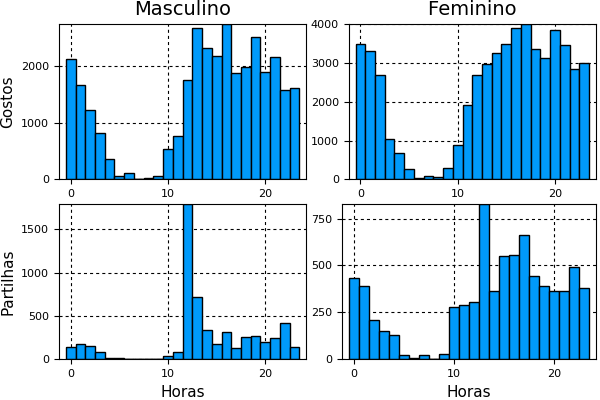

In [56]:
male = filtered_by_gender2[filtered_by_gender2[:gender] .== "male",:]
female = filtered_by_gender2[filtered_by_gender2[:gender] .== "female",:]
delete!(male, :gender)
delete!(female, :gender)
male = aggregate(male, :hour, sum)
female = aggregate(female, :hour, sum)
male_likes = Plots.bar(male[:hour], male[:likes_sum], ylabel="Gostos", title="Masculino")
female_likes = Plots.bar(female[:hour], female[:likes_sum], title="Feminino")
male_shares = Plots.bar(male[:hour], male[:shares_sum], ylabel="Partilhas",xlabel="Horas")
female_shares = Plots.bar(female[:hour], female[:shares_sum],  xlabel="Horas", )
Plots.plot(male_likes,female_likes,male_shares,female_shares,layout=(2,2),legend=false)